Running Model-4: 4960it [00:01, 4214.06it/s]<?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Fitting node Ridge-4...


Running Model-4: 1530it [00:00, 4128.71it/s]          


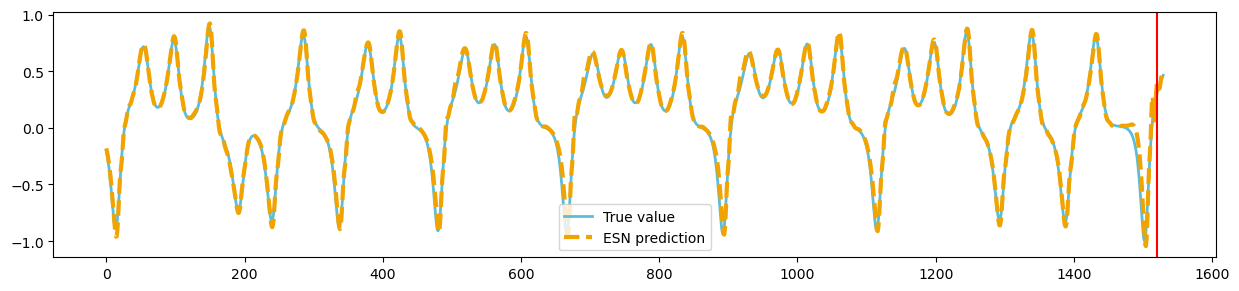

In [81]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

length = 6500
train = 4960
forecast = 10

###ПОДГОТОВКА ДАННЫХ
#9
import warnings

from nolitsa import data
dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]


x = data.lorenz(length=length, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
import copy
time = copy.deepcopy(x) 
X = time[:,0] 
X = X.reshape(length,1) 
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1 
    
def results(y_pred, y_test):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")

    ax.plot(np.arange(len(y_test)), y_test, lw=2, label="True value", color="#5cbdd9")
    ax.plot(np.arange(len(y_pred)), y_pred, lw=3, label="ESN prediction", color="#f1a300", linestyle="--")
    ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=forecast)

X_train1, y_train1 = x[:train], y[:train]
X_test1, y_test1 = x[train:], y[train:]

#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1)
results(y_pred1, y_test1)
###HERE1

In [82]:
X.shape

(6500, 1)

In [83]:
first_4920_values = X[:4920]
test = X[4920:4960]
array_of_arrays = [X[i:i+10] for i in range(4960, 6500, 10)]

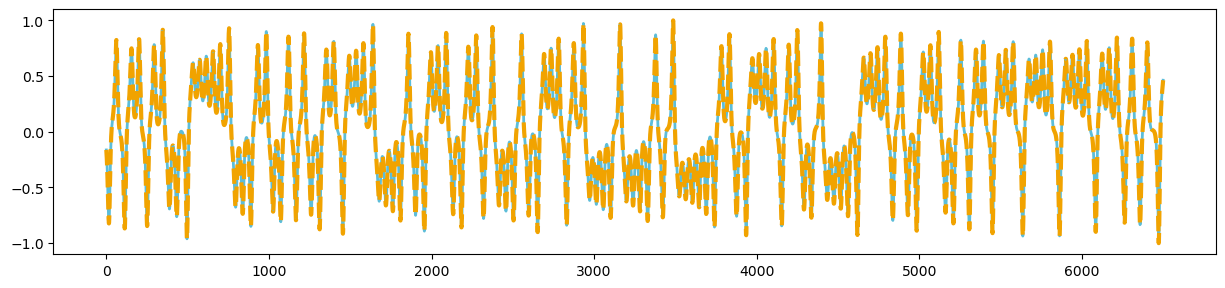

In [84]:
Y = first_4920_values
Y = np.concatenate([Y, test])
for i in range(len(array_of_arrays)):
    Y = np.concatenate([Y, array_of_arrays[i]])

fig = plt.figure(figsize=(15, 7))
ax = plt.subplot(211)
ax.plot(np.arange(len(X)), X, lw=2, color="#5cbdd9")
ax.plot(np.arange(len(Y)), Y, lw=3, color="#f1a300", linestyle="--")
plt.show()

In [85]:
len(X), len(Y), X.shape

(6500, 6500, (6500, 1))

In [108]:
len(array_of_arrays)

154

In [87]:
X_test1.shape

(1530, 1)

In [95]:
array_of_preds = []
y_pred1 = esn.run(test)
for i in range (len(array_of_arrays)): 
    array_of_preds.append(y_pred1)
    y_pred1 = esn.run(array_of_preds[i])

Running Model-4: 40it [00:00, 2771.58it/s]            
Running Model-4: 40it [00:00, 2222.27it/s]            
Running Model-4: 40it [00:00, 1739.53it/s]            
Running Model-4: 40it [00:00, 3338.62it/s]            
Running Model-4: 40it [00:00, 2666.56it/s]            
Running Model-4: 40it [00:00, 2667.28it/s]            
Running Model-4: 40it [00:00, 2499.73it/s]            
Running Model-4: 40it [00:00, 3333.18it/s]            
Running Model-4: 40it [00:00, 3639.39it/s]            
Running Model-4: 40it [00:00, 3335.23it/s]            
Running Model-4: 40it [00:00, 2502.16it/s]            
Running Model-4: 40it [00:00, 3635.76it/s]            
Running Model-4: 40it [00:00, 3334.10it/s]            
Running Model-4: 40it [00:00, 2499.47it/s]            
Running Model-4: 40it [00:00, 1738.73it/s]            
Running Model-4: 40it [00:00, 2858.03it/s]            
Running Model-4: 40it [00:00, 2666.52it/s]            
Running Model-4: 40it [00:00, 3078.67it/s]            
Running Mo

In [120]:
y_pred = np.empty((0, 1))
for i in range(len(array_of_arrays)):
     y_pred = np.concatenate([y_pred, array_of_preds[i][30:]])

In [121]:
len(array_of_preds)

154

In [122]:
y_pred.shape

(1540, 1)

In [124]:
tmp = np.full(4960, None)
y_pred = np.concatenate([tmp.reshape(len(y_train1), 1), y_pred])